In [5]:
get_ipython().magic('matplotlib notebook')
import pandas as pd
import numpy as np
#Load Data Set with Lebron's statistics
df = pd.read_csv('lebron_gameW_pred.csv', sep=';')
df['W'] = np.where(df['W'] == True, 1, 0)

In [6]:
#see the lenght of the datasets, features, and data types
len(df)
print(df.dtypes)

W                                          int32
Lebron James:points                        int64
Lebron James:assists                       int64
Lebron James:blocks                        int64
Lebron James:defensive rebounds            int64
Lebron James:field goals attempted         int64
Lebron James:field goals made              int64
Lebron James:fouls                         int64
Lebron James:free throws attempted         int64
Lebron James:free throws made              int64
Lebron James:minutes                     float64
Lebron James:offensive rebounds            int64
Lebron James:rebounds                      int64
Lebron James:steals                        int64
Lebron James:three pointers attempted      int64
Lebron James:three pointers made           int64
Lebron James:turnovers                     int64
dtype: object


In [8]:
#checking on multicollinearity 
df1 = df.drop(['W'], axis=1)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Before checking the multicollinearity, adding the constant into the model
X = add_constant(df1)
pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)

C:\Users\mluksik\PycharmProjects\googleapi\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                                    63.799333
Lebron James:points                            inf
Lebron James:assists                      1.090183
Lebron James:blocks                       1.027010
Lebron James:defensive rebounds                inf
Lebron James:field goals attempted        3.697407
Lebron James:field goals made                  inf
Lebron James:fouls                        1.078339
Lebron James:free throws attempted        7.911521
Lebron James:free throws made                  inf
Lebron James:minutes                      1.748442
Lebron James:offensive rebounds                inf
Lebron James:rebounds                          inf
Lebron James:steals                       1.026063
Lebron James:three pointers attempted     3.260086
Lebron James:three pointers made               inf
Lebron James:turnovers                    1.069203
dtype: float64

In [10]:
# Dropping out conflicting features based on the previous results
# One by one -> drop one feature and then check again as long as a multicollinearity is present
df1 = df.drop(['W', 'Lebron James:three pointers made', 'Lebron James:defensive rebounds', 'Lebron James:offensive rebounds', 'Lebron James:field goals made', 'Lebron James:free throws made'], axis=1)

# The final pick of features and the results of multicollinearity check
X = add_constant(df1)
pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)

const                                    63.560531
Lebron James:points                       2.755723
Lebron James:assists                      1.082930
Lebron James:blocks                       1.026304
Lebron James:field goals attempted        2.800347
Lebron James:fouls                        1.076662
Lebron James:free throws attempted        1.512867
Lebron James:minutes                      1.736238
Lebron James:rebounds                     1.140668
Lebron James:steals                       1.024552
Lebron James:three pointers attempted     1.345486
Lebron James:turnovers                    1.063781
dtype: float64

In [12]:
### Creating Validation scores on 4 folds of train and test sets in order to prevent overfitting while controlling the C parameter of Logistic Regression:
    ### 4 splits ensure that all the data points will be tested
        ### later, the 75:25 (train set : test set) will be used
        
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression

### Splitting the data on dependent and independet variables
X = df1
y = df['W']

### Testing the validation scores on a range of C parameters in order to find a suitable 
param_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
train_scores, test_scores = validation_curve(LogisticRegression(), X, y,
                                            param_name='C',
                                            param_range=param_range, cv=4)

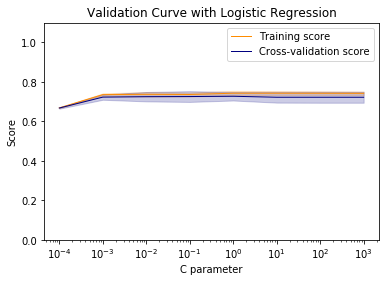

In [13]:
# This code based on scikit-learn validation_plot example
# See:  http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with Logistic Regression')
plt.xlabel('C parameter')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 1

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

In [147]:
# From the Validation Curve, we can see that the data set doesn't tend to significantly over-fit in any stage of the validation.
# When the C parameter = 1, the Cross-Validation score has the lowest spread. 
# But we should also pay attention to the results when the C parameter = 0.001, and investigate the performance further.

In [16]:
# Based on the results, let's further investigate the accuracy, AUC, recall and precision.

##### Cross-validation with the test for the variance of C-parameter (narrowed down to tree options based on the Validation Curve.
from sklearn.model_selection import cross_val_score

for c_param in [0.001, 1, 10]:
    clf = LogisticRegression(C=c_param)

    # accuracy is the default scoring metric
    print('For C parameter = {0}'.format(c_param) + ':')
    print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=4))
    # use AUC as scoring metric
    print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=4, scoring = 'roc_auc'))
    # use recall as scoring metric
    print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=4, scoring = 'recall'))
       # use recall as scoring metric
    print('Cross-validation (precesion)', cross_val_score(clf, X, y, cv=4, scoring = 'precision'))

For C parameter = 0.001:
Cross-validation (accuracy) [0.72254335 0.74127907 0.72383721 0.70348837]
Cross-validation (AUC) [0.75618441 0.77235618 0.75234479 0.73647238]
Cross-validation (recall) [0.83043478 0.97379913 0.97816594 0.94759825]
Cross-validation (precesion) [0.77016129 0.72875817 0.7133758  0.70684039]
For C parameter = 1:
Cross-validation (accuracy) [0.70231214 0.76162791 0.72383721 0.72093023]
Cross-validation (AUC) [0.75532234 0.81594836 0.75762294 0.74881337]
Cross-validation (recall) [0.71304348 0.90829694 0.90393013 0.90829694]


Cross-validation (precesion) [0.8159204  0.7732342  0.73928571 0.73498233]
For C parameter = 10:
Cross-validation (accuracy) [0.69075145 0.76453488 0.72383721 0.70930233]
Cross-validation (AUC) [0.74977511 0.81837858 0.76210366 0.74885134]
Cross-validation (recall) [0.69130435 0.90829694 0.90393013 0.90393013]
Cross-validation (precesion) [0.81538462 0.7761194  0.73928571 0.72631579]


In [149]:
# As we can see, the performance with the C = 10 is performing worse than C=1, 
    # -> the first fold suggest that the accuracy and also recall is bellow 0.7, while the rest of the fold is nearly identical.

# Comparing C = 0.001 and C=1:
#  -> the accuracy is played by the C=1 (2 folds are better, 1 equal and 1 worse)
#  -> Area Under the Curve is also better for C=1
#  -> The recall is much better in all folds for C = 0.001
    # however, that come with the price of lower precision. Yes, we aim for high recall, but... 
    # as the precission would often decrease under the level of 75%, we could be dealing with the
    # fact the model becomes a dummy classifier and detects (almost) everything as a W
    # this is not the desired outcome of the model, and therefore C=1 is a better option

# The goals it to create a classifier that will compute the probability of a Win (positive class) based on Lebron James' statistics from the game,
    # therefore I'd like to tune the model the way that the threshold for the W class is low (higher recall than precision)

In [17]:
# Let's investigate the Confusion Matrix, Accuracy, Precision, and Recall for C=1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = LogisticRegression(C=1).fit(X_train, y_train)

clf_predicted = clf.predict(X_test)
confusion = confusion_matrix(y_test, clf_predicted)

print('Logistic regression classifier (default settings)\n', confusion)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, clf_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, clf_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, clf_predicted)))

Logistic regression classifier (default settings)
 [[ 53  63]
 [ 30 199]]
Accuracy: 0.73
Precision: 0.76
Recall: 0.87


C:\Users\mluksik\PycharmProjects\googleapi\venv\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


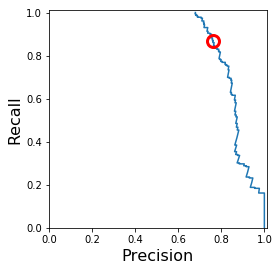

In [151]:
# ### Precision-recall curves
from sklearn.metrics import precision_recall_curve

# ### Decision functions
y_scores_lr = clf.fit(X_train, y_train).decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores_lr[0:20]))


precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

In [18]:
# The Recall and Precision trade-off is captured above. The current state of the model displayed by the red circle.

C = 0.001  accuracy = 0.728   AUC = 0.751
C = 1.000  accuracy = 0.730   AUC = 0.774


C:\Users\mluksik\PycharmProjects\googleapi\venv\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


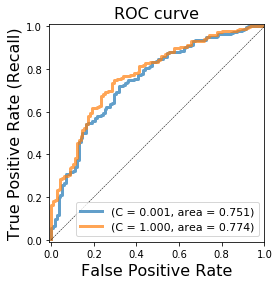

In [19]:
# Plotting the ROC curves for C=0,001 and C = 1
from sklearn.metrics import roc_curve, auc
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [0.001, 1]:
    clf = LogisticRegression(C=g).fit(X_train, y_train)
    y_score_svm = clf.decision_function(X_test)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    accuracy_svm = clf.score(X_test, y_test)
    print("C = {:.3f}  accuracy = {:.3f}   AUC = {:.3f}".format(g, accuracy_svm,
                                                                    roc_auc_svm))
    plt.plot(fpr_svm, tpr_svm, lw=3, alpha=0.7,
             label='(C = {:0.3f}, area = {:0.3f})'.format(g, roc_auc_svm))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

In [20]:
#The AUC for C=1 is higher, which also supports the decision to build the model this way.

In [27]:
# As the choice of the C parameter was done.
# The model complexity is not leading to over/under fitting => tested on 4 folds. 
# Let's fit the model to all the data points available in order to achieve the best performance
  # -> the number of observation has nothing to do with over fitting -> that is problem of the model complexity

clf = LogisticRegression(C=1).fit(X, y)

# Creating new observations from the NBA Finals Game 1,2,3,4 (previously not seen in the data set) -> and predict the W probability for these games.
# G1:
LBJ_stats_first_game_1 = {'Lebron James:points': [51],
                        'Lebron James:assists': [8],
                        'Lebron James:blocks':[1],
                        'Lebron James:field goals attempted': [32],
                        'Lebron James:minutes': [48],
                        'Lebron James:fouls':[2],
                        'Lebron James:steals': [1],
                        'Lebron James:three pointers attempted': [7],
                        'Lebron James:turnovers': [5],
                        'Lebron James:free throws attempted':[11],
                        'Lebron James:rebounds':[8]}

g1 = pd.DataFrame(data=LBJ_stats_first_game_1)
y_predict1 = clf.predict_proba(g1)
#G2:
LBJ_stats_first_game_2 = {'Lebron James:points': [29],
                        'Lebron James:assists': [13],
                        'Lebron James:field goals attempted': [20],
                        'Lebron James:blocks':[0],
                        'Lebron James:minutes': [44],
                        'Lebron James:fouls':[2],
                        'Lebron James:steals': [2],
                        'Lebron James:three pointers attempted': [4],
                        'Lebron James:turnovers': [5],
                        'Lebron James:free throws attempted':[9],
                        'Lebron James:rebounds':[9]}

g2 = pd.DataFrame(data=LBJ_stats_first_game_2)
y_predict2 = clf.predict_proba(g2)
#G3:
LBJ_stats_first_game_3 = {'Lebron James:points': [33],
                        'Lebron James:assists': [11],
                        'Lebron James:blocks':[2],                          
                        'Lebron James:field goals attempted': [28],
                        'Lebron James:minutes': [47],
                        'Lebron James:fouls':[2],
                        'Lebron James:steals': [2],
                        'Lebron James:three pointers attempted': [6],
                        'Lebron James:turnovers': [4],
                        'Lebron James:free throws attempted':[7],
                        'Lebron James:rebounds':[10]}

g3 = pd.DataFrame(data=LBJ_stats_first_game_3)
y_predict3 = clf.predict_proba(g3)

#G4:
LBJ_stats_first_game_4 = {'Lebron James:points': [23],
                        'Lebron James:assists': [8],
                        'Lebron James:field goals attempted': [13],                          
                        'Lebron James:blocks':[1],
                        'Lebron James:minutes': [41],
                        'Lebron James:fouls':[5],
                        'Lebron James:steals': [0],
                        'Lebron James:three pointers attempted': [1],
                        'Lebron James:turnovers': [6],
                        'Lebron James:free throws attempted':[11],
                        'Lebron James:rebounds':[7]}

g4 = pd.DataFrame(data=LBJ_stats_first_game_4)
y_predict4 = clf.predict_proba(g4)

print('Probability of Cavs winning the G1: ', y_predict1)
print('Probability of Cavs winning the G2: ', y_predict2)
print('Probability of Cavs winning the G3: ', y_predict3)
print('Probability of Cavs winning the G4: ', y_predict4)

Probability of Cavs winning the G1:  [[0.09273245 0.90726755]]
Probability of Cavs winning the G2:  [[7.36182468e-04 9.99263818e-01]]
Probability of Cavs winning the G3:  [[0.3253793 0.6746207]]
Probability of Cavs winning the G4:  [[0.01366418 0.98633582]]


In [28]:
# Obviously, the model was 4 times wrong -> as we know, Cavaliers lost all the 4 games.
# What does this mean? Basically just two things. And perhaps, most of us knew this all along:
    # 1.: Lebron James had done enough to increase the chance of the W in all 4 games, and it wasn't his fault that Cleveland had lost.
    # 2.: The model is not good enough to get close to the real probability. It simply needs more data to learn. 

# So let's feed it with one more feature -> the quality of the opponents Team.

In [29]:
# For model regularization, we might use one of many approaches... starting with Lasso, Ridge regression... ending with Recursive Feature Elimination with Scikit Learn.
# Also, we can create a decision tree and see the feature importance and eliminate few features this way.
# #### Creating a Decision Tree Classifier

%matplotlib inline
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 8,
                            random_state = 0).fit(X, y)

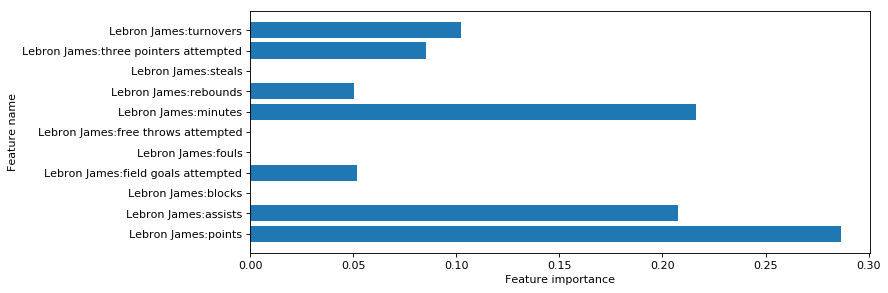

Feature importances: [0.28638496 0.20734396 0.         0.05182253 0.         0.
 0.21628852 0.05038839 0.         0.08532076 0.10245087]
['Lebron James:points', 'Lebron James:assists', 'Lebron James:blocks', 'Lebron James:field goals attempted', 'Lebron James:fouls', 'Lebron James:free throws attempted', 'Lebron James:minutes', 'Lebron James:rebounds', 'Lebron James:steals', 'Lebron James:three pointers attempted', 'Lebron James:turnovers']


In [31]:
# Plotting the feature importance and eliminating features from the next model: blocks, fouls, free throws attempted, steals.
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, list(X_train))
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))
print(list(X_train))